# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [2]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)
    
X_train_PR = X_train
X_test_PR = X_test

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []

enumerate_kfold = list(enumerate(kfold))
for epoch in range(num_epochs):
    for k, (train, test) in enumerate_kfold:
        clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))
        score = clf.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 1.000
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 1.000
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.978
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 1.000
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 8, Class di

## Answer

Becuase in the code above, the core error is he only use one model to train different fold for cross validation.
using function partial_fit(), which will lead to the model 'remember' previous training result parameter and let the cross validation of no use.

The correct answer is to replace the partial_fit() to fit() when epoch is 0, which means every new fold we adapt a model with new hyperparameters.

Code are appended below.

In [7]:

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []
for k, (train, test) in list(enumerate(kfold)):
    for epoch in range(num_epochs):
        if epoch == 0:
            clf.fit(X_train_std[train], y_train[train])
        else:
            clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))
        score = clf.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.935

Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 0.978

Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.957

Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.978

Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 0.978

Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 0.978

Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.933
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.978

Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.978

Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 8, Class dist.: [257 153], Acc: 0.978

Epoch: 0, Fold: 9, 

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

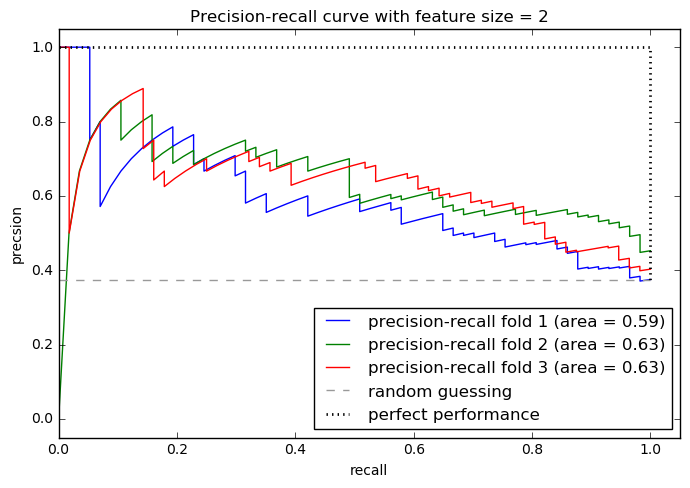

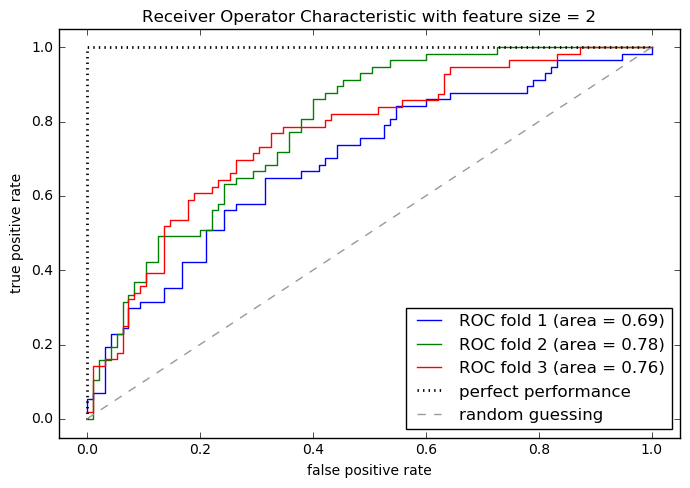

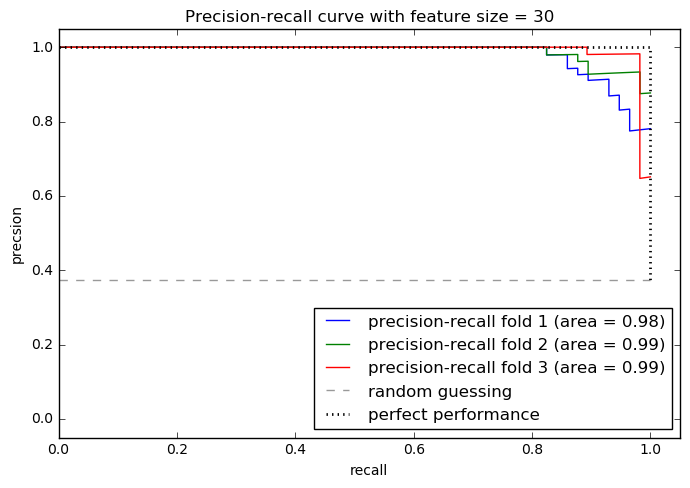

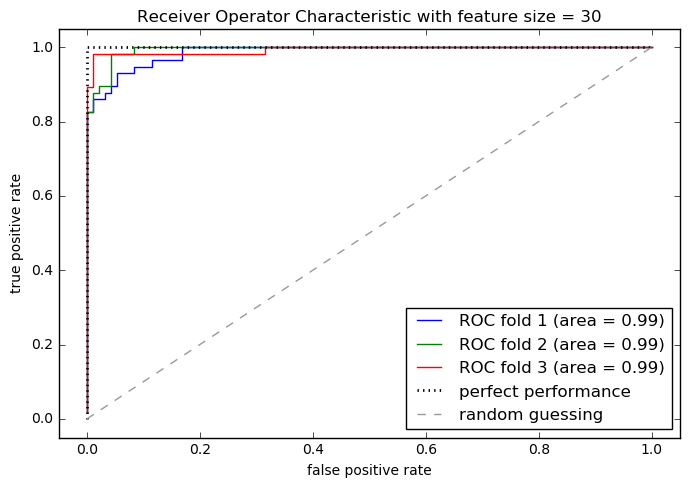

In [23]:
# your code

# set up the experiment
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])




for X_train, X_test in list(zip([X_train_PR[:, [4, 14]],X_train_PR], [X_test_PR[:, [4, 14]], X_test_PR])):
    if Version(sklearn_version) < '0.18':
        cv = StratifiedKFold(y_train, 
                             n_folds=3, 
                             random_state=1)    
    else:
        cv = list(StratifiedKFold(n_splits=3, 
                                  random_state=1).split(X_train, y_train))
    fig = plt.figure(figsize=(7, 5))

    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(X_train[train],
                             y_train[train]).predict_proba(X_train[test])

        precision, recall, thresholds = precision_recall_curve(y_train[test],
                                         probas[:, 1],
                                         pos_label=1)
        #mean_tpr[0] = 0.0
        roc_auc = auc(recall, precision)
        plt.plot(recall,
                 precision,
                 lw=1,
                 label='precision-recall fold %d (area = %0.2f)'
                       % (i+1, roc_auc))
    plt.plot([0, 1],
         [sum(y_train == 1) / y_train.shape[0], sum(y_train == 1) / y_train.shape[0]],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
    plt.plot([0, 1, 1],
         [1, 1, sum(y_train == 1) / y_train.shape[0]],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')
    plt.xlim([0, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('recall')
    plt.ylabel('precsion')
    plt.title('Precision-recall curve with feature size = ' + str(X_train.shape[1]))
    plt.legend(loc="lower right")

    plt.tight_layout()
    # plt.savefig('./figures/roc.png', dpi=300)
    plt.show()
    fig = plt.figure(figsize=(7, 5))

    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(X_train[train],
                             y_train[train]).predict_proba(X_train[test])

        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, 1],
                                         pos_label=1)
        #mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 lw=1,
                 label='ROC fold %d (area = %0.2f)'
                       % (i+1, roc_auc))
    plt.plot([0, 0, 1],
             [0, 1, 1],
             lw=2,
             linestyle=':',
             color='black',
             label='perfect performance')
    plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic with feature size = ' + str(X_train.shape[1]))
    plt.legend(loc="lower right")

    plt.tight_layout()
    # plt.savefig('./figures/roc.png', dpi=300)
    plt.show()

## Answer
### observation:
$\bullet$ Similarities:
1. In both case, the better classification will have larger area below its curve
2. Both of the curve have a basic tendency, ROC is TPR increase with FPR increases, and precision-recall curve is like precision reduces with recall increase.

$\bullet$ Differences:
1. ROC curve is strictly increaseing, but precision-recall curve is not that rigid, it varies a bit but with a basic decreasing tendency
2. all curves in ROC will start at (0,0) and end at (1,1), while precision-recall curves are not strict
<a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic"><img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/ROCfig.PNG" align=right></a>

### explanation:
Here we first copy the definition from lecture notes:

TPR (true positive rate) = $\frac{TP}{TP+FN}$
<br>
FPR (false positive rate) = $\frac{FP}{FP+TN}$

PRE (precision) = $\frac{TP}{TP+FP}$
<br>
REC (recall) = TPR

So now it's easy for us to figure out why they have such simlarities and difference.

$\bullet$  ROC curve:
Here appended a clear figure from Wikipedia:

We can find out that if the data set is seperatable in terms of the field we spot, then we can increse the TPR by increase FPR, in other words, we are trying to sacifice misrecognize the negative data to be positive to gurantee that more positive data can be find by recognition. 
So that is why the ROC curve is strictly start from (0,0) and end at (1,1), that two points stands for we classify all data as negative and positive.

$\bullet$  precision-recall curve:

From the definition we found that those two fields, precision and recall, are two parts that we would like to optimize and balance, we both want high precision and high recall, but we can find that it could be hard to balance that.
Becuase to increase precision, which means all we pick as positive, we want less data whose ground truths are negative. In other words, we want our model more strict and not as tolerate too much soley to pursue TPR. But in this way it could be happen with high possibility that we will classify more data whose ground truths are positive as negative ones, leading to low recall rate.
But it will involves many variables like features choices, normalization and others, it is not clear that precision and recall are 100% negative related, so it won't show strict decreasing monotonicity.

# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [9]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [12]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [13]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


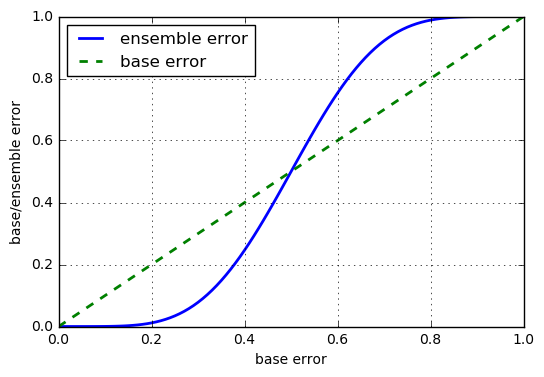

In [14]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensemble error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [15]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    classfier_range = np.arange(1, max_num_classifier + 1)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=base_error) for num_classifier in classfier_range]

    plt.plot(classfier_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
   
    plt.xlabel('number of classfiers')
    plt.ylabel('ensemble erros')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

State your observations of the experiments of your code...

In [16]:
max_num_classifiers = 20
base_error = 0.25

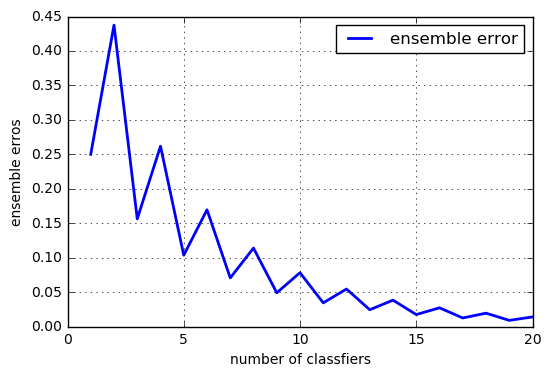

In [17]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

# observation:

We can find that in the ploting, the ensemble errors with respect of the number of the classfiers are not always decreasing with the number of classifers increase.

For every point when the number of the classfiers are even number, the ensemble error will go up, this is because the algorithm calculate the ensemble error is not accurate, the original one will treat the tie case (the number of positive choices are equal to negative), at this point, intuitively we will pick one tag randomly, so it could have also 50% error to make in this tie case.

So in the code below I try to add 0.5 * (probablity of tie) to the error the result show that we end up with strictly decreasing function, which shows satisfied result.

Below is the proof that why in this case the ensemble error of 2k-1 classifiers is equal to the ensemble error of 2k classifiers

$$
\begin{align}
P(\text{2k classfiers error}) &= P(\text{2k classfiers error | at least k+1 error for first 2k-1 classfiers}) * P(\text{at least k+1 error for first 2k-1 classfiers})\\
&+ P(\text{2k classfiers error | exactly k error for first 2k-1 classfiers}) * P(\text{exactly k error for first 2k-1 classfiers})\\
&+ P(\text{2k classfiers error | exactly k-1 error for first 2k-1 classfiers}) * P(\text{exactly k-1 error for first 2k-1 classfiers})\\
&+ P(\text{2k classfiers error | at most k-2 error for first 2k-1 classfiers}) * P(\text{at most k-2 error for first 2k-1 classfiers})\\
&= 1 \times \sum_{i=k+1}^{2k-1} \left(\binom{2k-1}{i}\epsilon^{i}(1-\epsilon)^{2k-1-i}\right) + \left(\epsilon + \frac{1-\epsilon}{2}\right)\left(\binom{2k-1}{k}\epsilon^{k}(1-\epsilon)^{k-1}\right) + \frac{\epsilon}{2}\left(\binom{2k-1}{k-1}\epsilon^{k-1}(1-\epsilon)^{k}\right) \\
&= \sum_{i=k+1}^{2k-1} \left(\binom{2k-1}{i}\epsilon^{i}(1-\epsilon)^{2k-1-i}\right) + \epsilon\left(\binom{2k-1}{k}\epsilon^{k}(1-\epsilon)^{k-1}\right) + \left(\binom{2k-1}{k}\epsilon^{k}(1-\epsilon)^{k}\right)\\
&= \sum_{i=k+1}^{2k-1} \left(\binom{2k-1}{i}\epsilon^{i}(1-\epsilon)^{2k-1-i}\right) + (1-\epsilon + \epsilon)\left(\binom{2k-1}{k}\epsilon^{k}(1-\epsilon)^{k-1}\right)\\
&= \sum_{i=k+1}^{2k-1} \left(\binom{2k-1}{i}\epsilon^{i}(1-\epsilon)^{2k-1-i}\right) + \left(\binom{2k-1}{k}\epsilon^{k}(1-\epsilon)^{k-1}\right) = \sum_{i=k}^{2k-1} \left(\binom{2k-1}{i}\epsilon^{i}(1-\epsilon)^{2k-1-i}\right)\\
&= P(\text{2k-1 classfiers error})
\end{align}
$$

In [18]:
def better_ensemble_error(num_classifier, base_error):
    if num_classifier % 2 == 1:
        k_start = math.ceil(num_classifier/2)
        probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]

    else:
        k_start = math.ceil(num_classifier/2) + 12
        probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
        probs.append(0.5*comb(num_classifier, k_start-1)*(base_error**(k_start-1))*((1-base_error)**(num_classifier-k_start+1)))
    return sum(probs)

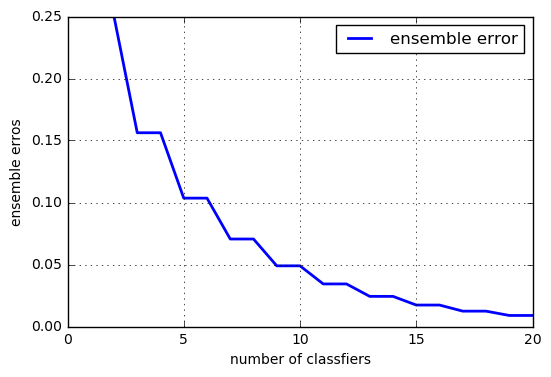

In [19]:
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)